In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import awkward as ak
import seaborn as sn
from fast_histogram import histogram2d

In [35]:
#data_path = "/disk/atlas3/data_MC/ATLASOpen/jets/part1.root" 
ttbar_data_path = "/disk/atlas3/data_MC/delphes/ttbar_13TeV_taus_1000events.root:Delphes" 
#ttbar_data_path = "/disk/atlas3/data_MC/delphes/directW_13TeV_taus_100_1000events.root:Delphes"
directW_data_path = "/disk/atlas3/data_MC/delphes/directW_13TeV_taus_100_1000events.root:Delphes" 
#data_path = "../../Delphes-3.5.0/directW_13TeV.root:Delphes" 

These are some examples of how to look at root files using uproot and awkward arrays. More info in this tutorial:
https://hub.gke2.mybinder.org/user/jpivarski-2020--ep2020-tutorial-7h7oraqf/lab/tree/tutorial.ipynb


In [36]:
def cal_image_plot(ax):
    """
    Formating of calorimeter image
    """
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    #ax.set_title("Calorimeter image", fontsize=20, color="black")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

def zero_to_nan(arr):
    """
    converts the zeros to NaN to avoid confusion
    """
    clusters = arr.clusters
    clusters.E = ak.where(clusters.E == 0, np.nan, clusters.E)
    clusters.x = ak.where(clusters.x == 0, np.nan, clusters.x)
    clusters.y = ak.where(clusters.y == 0, np.nan, clusters.y)
    clusters.z = ak.where(clusters.z == 0, np.nan, clusters.z)
    arr.clusters = clusters
    return arr

def cartesian_to_angles(arr, drop:bool=False):
    """
    converts cartesian coordinates to polar angles
    """
    clusters = arr.clusters
    clusters["pT"] = np.sqrt(clusters.x**2 + clusters.y**2)
    clusters["eta"] = np.arcsinh(clusters.z/clusters["pT"])
    clusters["phi"] = np.arcsin(clusters.y/clusters["pT"])
    """
    Add this functionality: drop old values
    if drop:
    """
    arr.clusters = clusters
    return arr

In [37]:
#Open file in with-function will close it when you exit
def look(rootfile:str):
    with uproot.open(rootfile) as file:
        keys = file.keys()
        print(keys)
        #print(file.show())
        #print(file["Tower"].keys())
        #print(file["Tower"]["Tower.ET"].array())

def load_data(rootfile:str, branch:str, keys:list):
    with uproot.open(rootfile) as file:
        valid_list = [key in file.keys() for key in keys]
        if valid_list:
            arr = file[branch].arrays(keys, library="ak", how="zip")
            return arr[branch]
        else:
            print(keys[not(valid_list)], " not present in data.")


#look(data_path)
ttbar_clusters = load_data(ttbar_data_path, "Tower", 
                        ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad"])
directW_clusters = load_data(directW_data_path, "Tower", 
                            ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad"])
#print(ak.to_list(clusters[0]))
max_hits = np.max([len(item) for item in ttbar_clusters["ET"]])
print(max_hits)
ttbar_clusters = ak.pad_none(ttbar_clusters, max_hits, axis=-1)
directW_clusters = ak.pad_none(directW_clusters, max_hits, axis=-1)

489


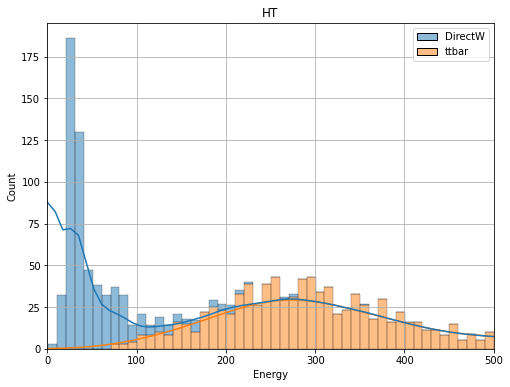

In [44]:
ttbar_events =  load_data(ttbar_data_path, "ScalarHT", ["ScalarHT.HT"])
directW_events =  load_data(directW_data_path, "ScalarHT", ["ScalarHT.HT"])
ttbar_HT = ak.to_list(ak.flatten(ttbar_events.HT[ttbar_events.HT>1]))
directW_HT = ak.to_list(ak.flatten(directW_events.HT[ttbar_events.HT>1]))
#HT distribution
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"DirectW": directW_HT, "ttbar": ttbar_HT}, bins=50, binrange=[1, 500], ax = ax, kde=True, multiple="stack", stat="count")
ax.set_title("HT")
ax.set_xlabel("Energy")
ax.set_xlim(0,500)
#ax.set_yscale('log')
ax.grid(visible=None)

In [23]:
#clusters["EZ"] = clusters["ET"]*np.sinh(clusters["Eta"])
#clusters["EX"] = clusters["ET"]*np.cos(clusters["Phi"])
#clusters["EY"] = clusters["ET"]*np.sin(clusters["Phi"])

In [24]:
#Extracting data for plotting
ttbar_largest_ET = ak.argmax(ttbar_clusters.ET, axis=-1, keepdims=True)
ttbar_eta = ak.to_list(ak.flatten(ttbar_clusters.Eta[ttbar_largest_ET]))
ttbar_phi = ak.to_list(ak.flatten(ttbar_clusters.Phi[ttbar_largest_ET]))
ttbar_ET = ak.to_list(ak.flatten(ttbar_clusters.ET[ttbar_largest_ET]))

directW_largest_ET = ak.argmax(directW_clusters.ET, axis=-1, keepdims=True)
directW_eta = ak.to_list(ak.flatten(directW_clusters.Eta[directW_largest_ET]))
directW_phi = ak.to_list(ak.flatten(directW_clusters.Phi[directW_largest_ET]))
directW_ET = ak.to_list(ak.flatten(directW_clusters.ET[directW_largest_ET]))

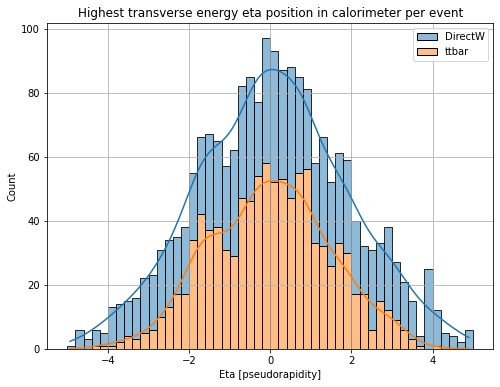

In [25]:
#Eta distribution
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"DirectW": directW_eta, "ttbar": ttbar_eta}, ax = ax, bins=50, binrange=[-5,5], kde=True, multiple="stack", stat="count")
ax.set_title("Highest transverse energy eta position in calorimeter per event")
ax.set_xlabel("Eta [pseudorapidity]")
#ax.set_yscale('log')
ax.grid(visible=None)

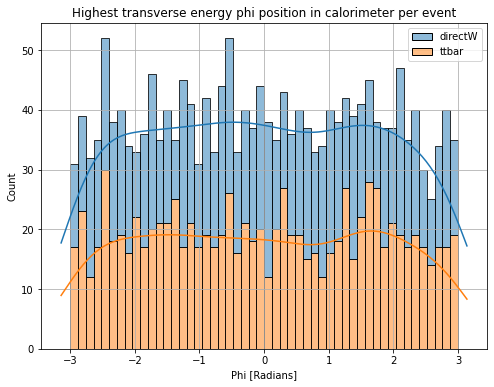

In [26]:
#Phi distribution, should be uniform
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"directW": directW_phi, "ttbar": ttbar_phi}, ax = ax, bins=50, binrange=[-3,3], kde=True, multiple="stack", stat="count")
ax.set_title("Highest transverse energy phi position in calorimeter per event")
ax.set_xlabel("Phi [Radians]")
#ax.set_yscale('log')
ax.grid(visible=None)

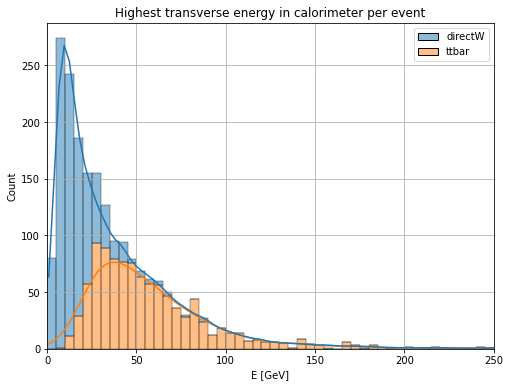

In [27]:
#Energy distribution
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"directW": directW_ET, "ttbar": ttbar_ET}, ax = ax, bins=50, binrange=[0,250], kde=True, multiple="stack", stat="count")
ax.set_title("Highest transverse energy in calorimeter per event")
ax.set_xlabel("E [GeV]")
ax.set_xlim(0, 250)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.grid(visible=None)

In [28]:
#Converting to images
MAX_EVENTS = 100
RESOLUTION = 80

def create_histograms(x, y, z):
    max_available_events = len(x)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    Cal = [histogram2d(x[i], y[i], 
            range=[[-np.pi, np.pi], [-5, 5]], bins=RESOLUTION, 
            weights=z[i]) 
            for i in range(0, max_events)]
    #Cal = [histogram2d(event.phi, event.eta, range=[[-np.pi, np.pi], [-2.5, 2.5]], bins=RESOLUTION) for event in array[:max_events]]
    return Cal


hists = create_histograms(ak.to_numpy(directW_clusters.Phi), ak.to_numpy(directW_clusters.Eta), ak.to_numpy(directW_clusters.ET))

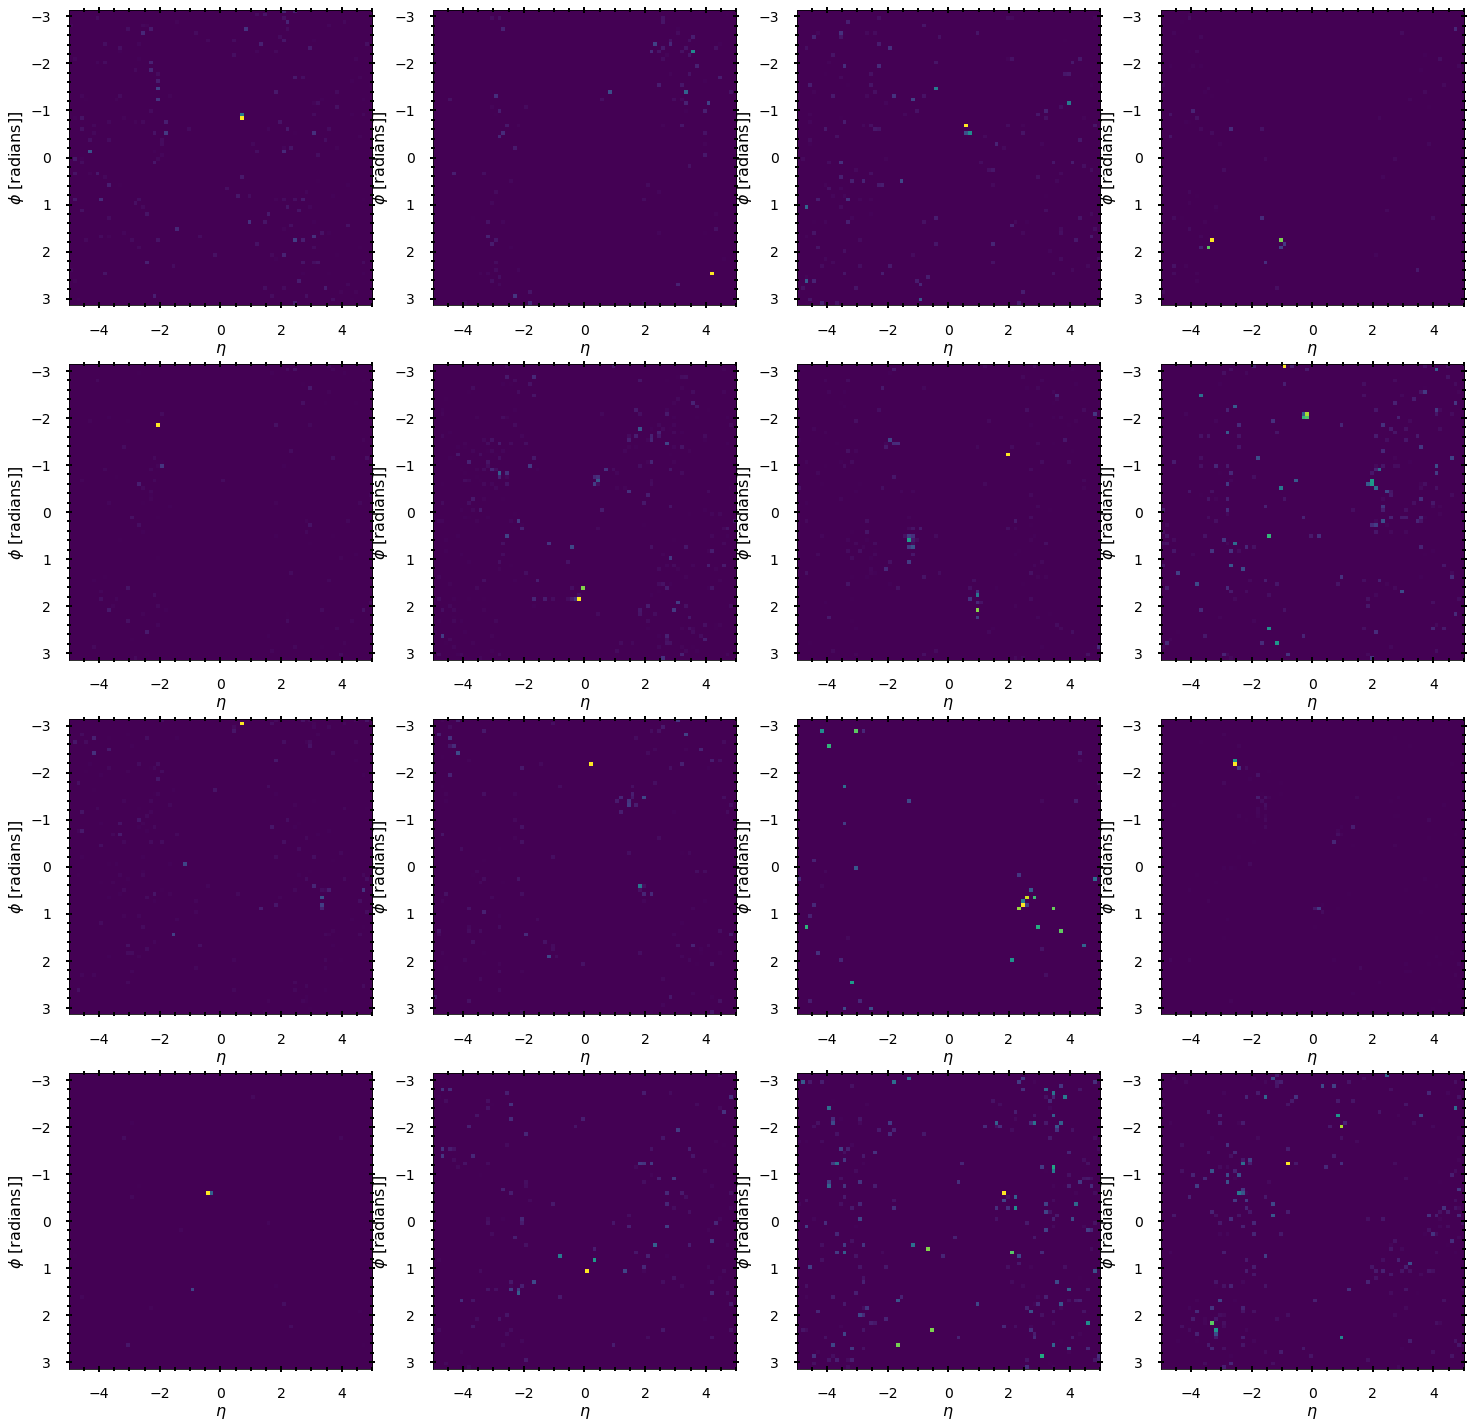

In [29]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (25,25))
images = np.random.randint(0, high=len(hists), size=(4,4))
for i in range(4):
    for j in range(4):
        cal_image_plot(axs[i][j])
        axs[i][j].imshow(hists[images[i][j]], extent=[-5, 5, np.pi, -np.pi], aspect='auto')

In [30]:
#Converting to images
MAX_EVENTS = 100
RESOLUTION = 80

def create_histograms(x, y, z):
    max_available_events = len(x)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    
    Cal = [histogram2d(x[i], y[i], 
            range=[[-np.pi, np.pi], [-5, 5]], bins=RESOLUTION, 
            weights=z[i]) 
            for i in range(0, max_events)]
            
    return Cal


hists = create_histograms(ak.to_numpy(ttbar_clusters.Phi), ak.to_numpy(ttbar_clusters.Eta), ak.to_numpy(ttbar_clusters.ET))

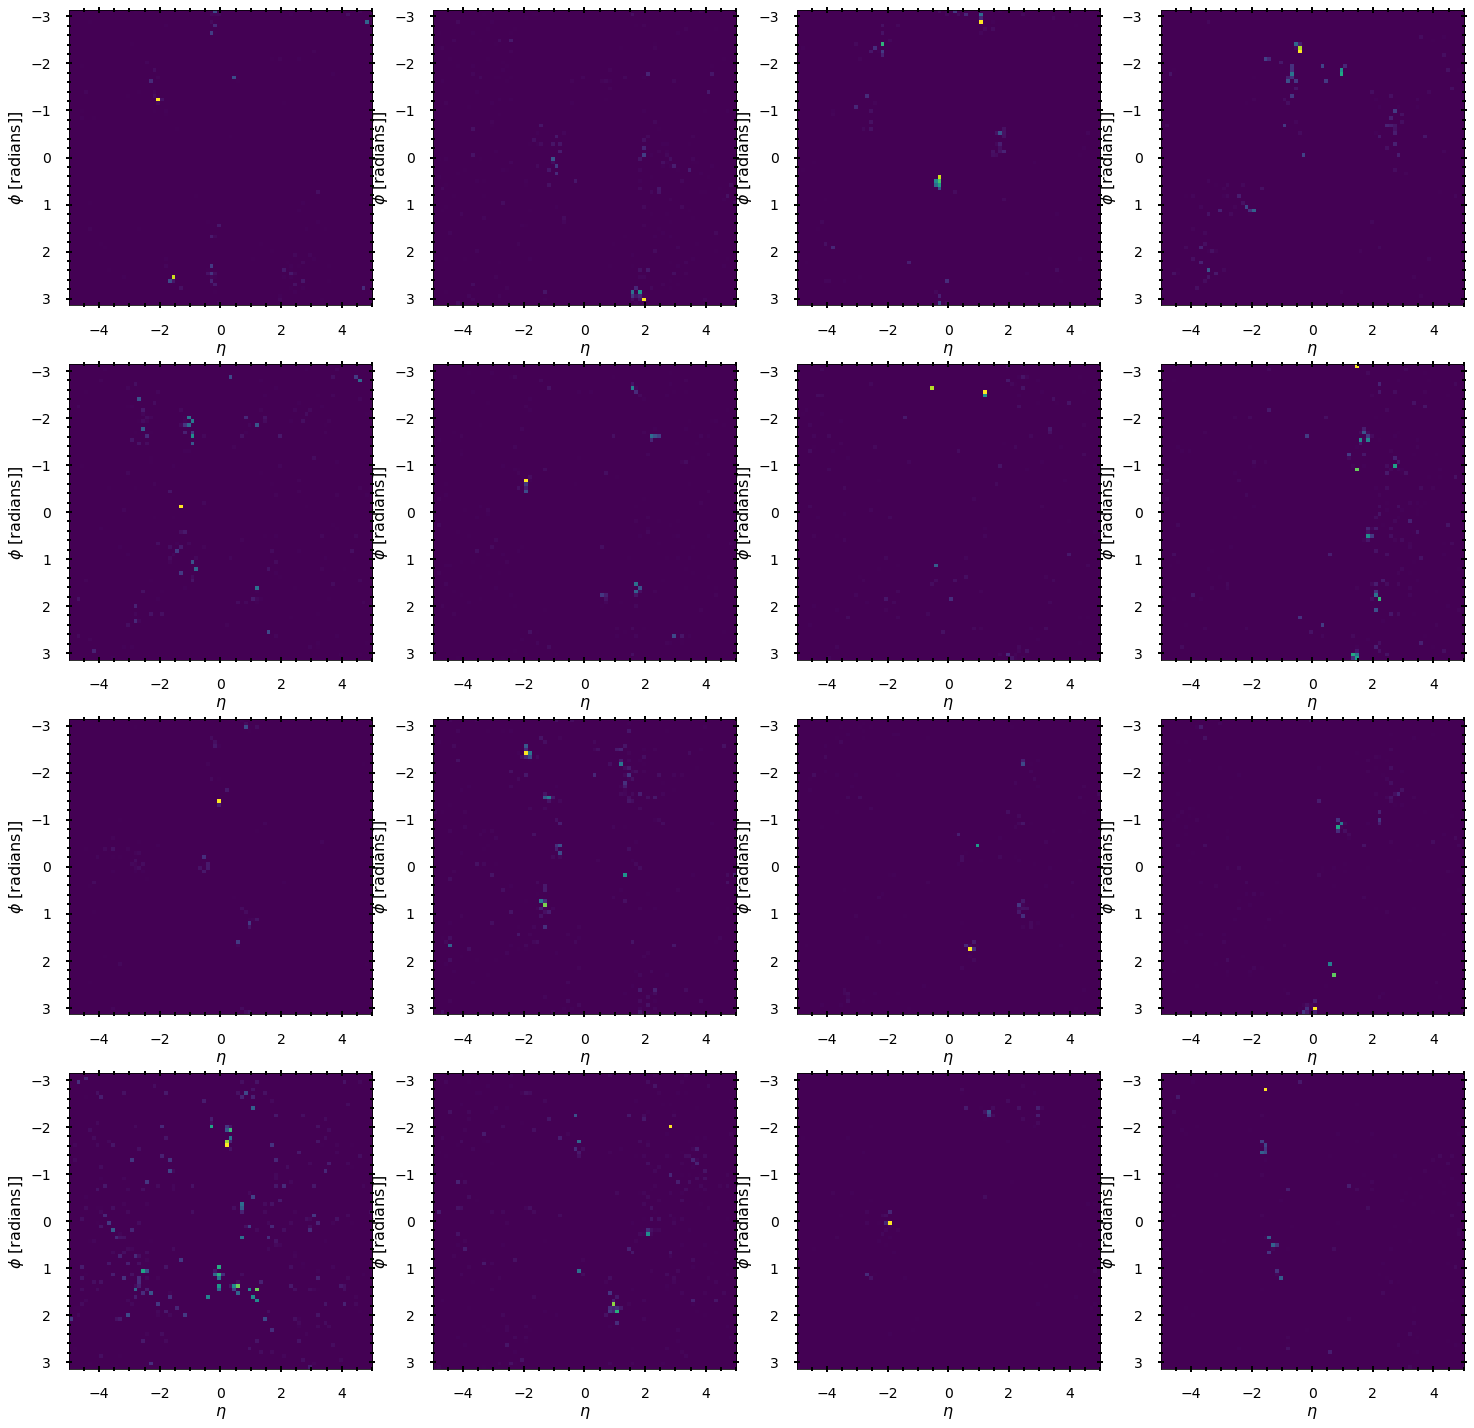

In [31]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (25,25))
images = np.random.randint(0, high=len(hists), size=(4,4))
for i in range(4):
    for j in range(4):
        cal_image_plot(axs[i][j])
        axs[i][j].imshow(hists[images[i][j]], extent=[-5, 5, np.pi, -np.pi], aspect='auto')

Text(0.5, 0, 'Tower transverse energy')

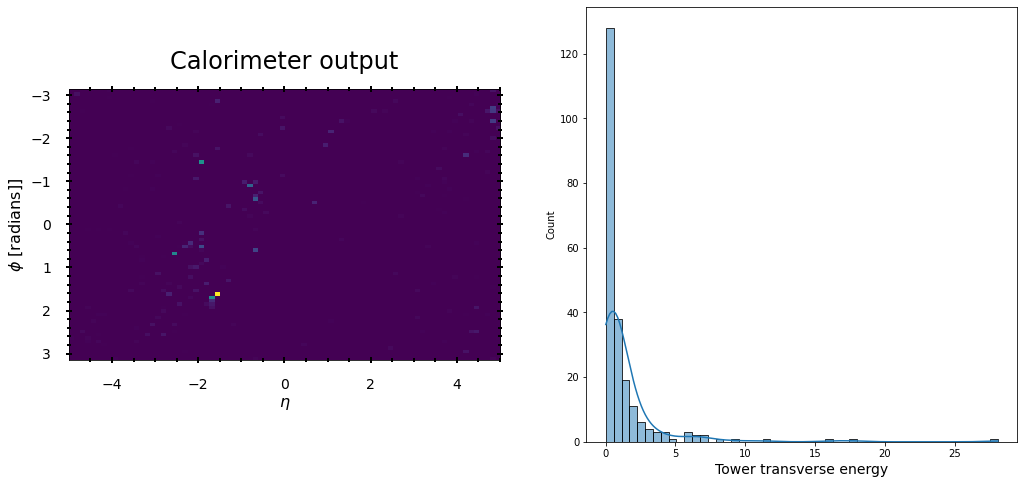

In [32]:
k = 2 #np.random.randint(0, high=len(hists)) #a random image
ET = ak.to_list(ttbar_clusters.ET[k])
def cal_image_plot(ax):
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    ax.set_title("Calorimeter output", fontsize=24, color="black", pad=20)
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 8))
cal_image_plot(axs[0])
axs[0].imshow(hists[k], extent=[-5, 5, np.pi, -np.pi], aspect='equal')
sn.histplot(ET, ax = axs[1], bins=50, kde=True, stat="count")
axs[1].set_xlabel("Tower transverse energy", fontsize=14)

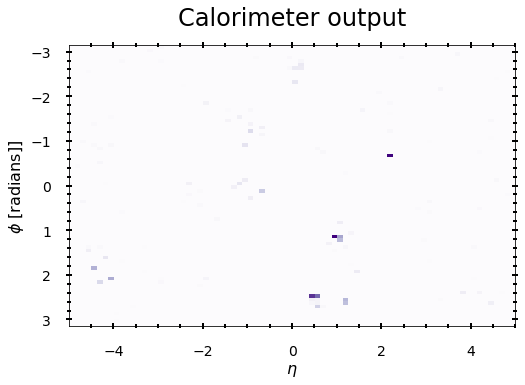

In [33]:
k = 59 #np.random.randint(0, high=len(hists)) #a random image
ET = ak.to_list(ttbar_clusters.ET[k])

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 8))
cal_image_plot(axs)
axs.imshow(hists[k], cmap='Purples', extent=[-5, 5, np.pi, -np.pi], aspect='equal')

In [34]:
event = ttbar_clusters[k]
print(ak.sort(ttbar_clusters.ET[k], ascending=False))
index = ak.argsort(event.ET, ascending=False, axis=-1)[0:20]
print(index)
eta = ak.to_list(event.Eta[index])
phi = ak.to_list(event.Phi[index])
ET = ak.to_list(event.ET[index])
df = pd.DataFrame({"Eta": eta, "Phi": phi, "Energy": ET})
print(df)

[24.2, 23.9, 16.9, 16.6, 10.7, 10.2, 9.66, ... None, None, None, None, None, None]
[69, 109, 106, 107, 90, 2, 113, 114, 104, ... 112, 91, 36, 101, 99, 89, 105, 49, 42]
         Eta       Phi     Energy
0   2.172503 -0.669803  24.166317
1   0.904431  1.115211  23.933071
2   0.439945  2.502569  16.906857
3   0.596155  2.494045  16.619669
4  -4.105590  2.054705  10.701424
5  -4.419693  1.879999  10.239250
6   1.169677  2.564012   9.659050
7   1.175590  2.627090   8.819213
8  -0.673896  0.129860   7.702665
9   0.539094  2.718163   7.010648
10  1.051685  1.174931   6.396325
11  1.113123  1.202865   6.168458
12 -4.275257  2.132061   6.063265
13 -0.891032 -1.225360   5.681959
14 -1.091192 -0.893767   4.597994
15 -1.209967 -0.058175   4.148610
16 -4.132674  1.610604   4.056393
17  0.029648 -2.333979   4.020136
18  0.454679  2.499578   3.695555
19  0.100428 -2.610074   3.383768


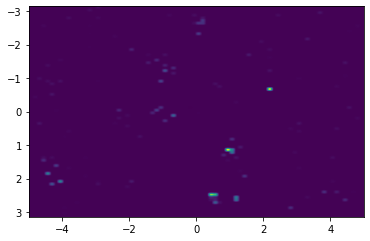

In [35]:
test = histogram2d(ak.to_numpy(event.Phi), ak.to_numpy(event.Eta), 
                    range=[[-np.pi, np.pi], [-5, 5]], bins=80, 
                    weights=ak.to_numpy(event.ET))
plt.imshow(test, extent=[-5, 5, np.pi, -np.pi])

In [36]:
print(test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
